<a href="https://colab.research.google.com/github/marcospgp/abstraction-and-reasoning/blob/master/Neural_Cellular_Automata_for_ARC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing the problem

In [11]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [12]:
!git clone https://github.com/fchollet/ARC.git

fatal: destination path 'ARC' already exists and is not an empty directory.


In [13]:
import os
import json

# task_file = "./ARC/data/training/00d62c1b.json"

task_files = sorted(os.listdir("./ARC/data/training"))

print("Filenames of first 3 training tasks:")
print(task_files[:3])

tasks = []

for filename in task_files:
    with open(f"./ARC/data/training/{filename}", "r") as f:
        tasks.append(json.load(f))

print("\nFirst task's keys:")
display(tasks[0].keys())

Filenames of first 3 training tasks:
['007bbfb7.json', '00d62c1b.json', '017c7c7b.json']

First task's keys:


dict_keys(['test', 'train'])

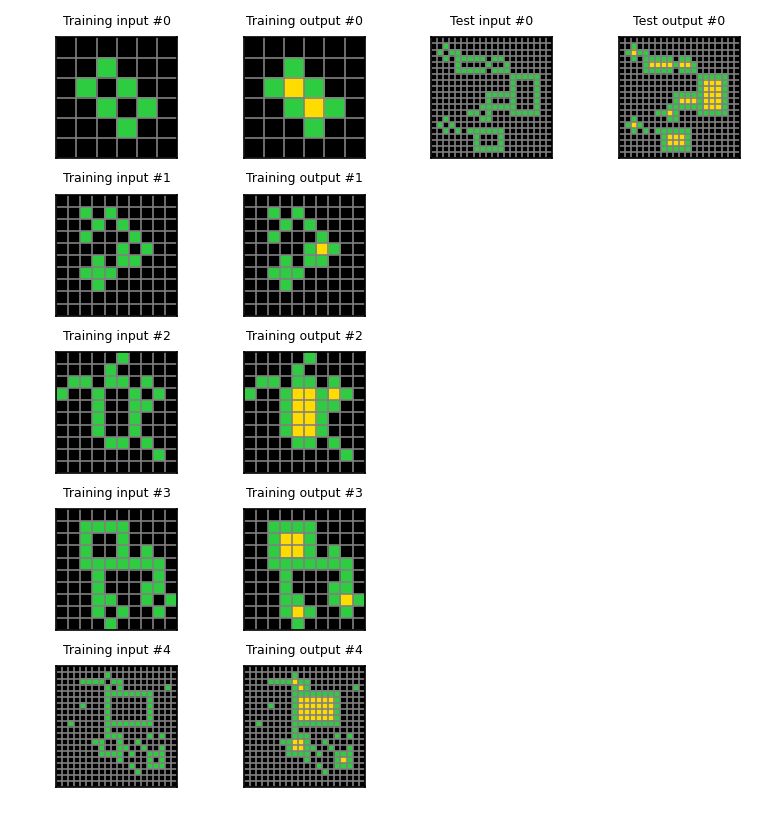

In [14]:
import matplotlib.pyplot as plt
from matplotlib import colors

cmap = colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40',
        '#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

# Draws a grid using pyplot.
# The grid wil be drawn wherever pyplot is currently pointed - so to draw inside
# a particular subplot, for example, simply call plt.subplot() before calling
# this function.
def plot_one_grid(grid):
    plt.imshow(grid, cmap=cmap, norm=norm, extent=(0, len(grid[0]), 0, len(grid)))
    plt.grid(True, color="gray")
    plt.tick_params(colors=(0, 0, 0, 0))
    plt.xticks(range(len(grid[0])))
    plt.yticks(range(len(grid)))

def display_grid(grid):
    """ Display a single grid """
    plt.figure()
    plot_one_grid(grid)
    plt.show()

def display_grid_pairs(xs, ys):
    rows = len(xs)
    cols = 2
    pos = 1
    plt.figure()
    for i, grid in enumerate(xs):
        plt.subplot(rows, cols, pos)
        plot_one_grid(grid)
        pos += 1
        plt.subplot(rows, cols, pos)
        plot_one_grid(ys[i])
        pos += 1
    plt.show()

def display_task(task, show_labels=True, size=(5, 5)):
    """
    Display a task's example and test grids
    """
    number_of_examples = len(task["train"])
    number_of_test_grids = len(task["test"])
    rows = max(number_of_examples, number_of_test_grids)

    # Adjust figsize and dpi to avoid misaligned grid lines
    # (https://stackoverflow.com/questions/53998166/python-matplotlib-misaligned-grid-lines-and-color-fills)
    plt.figure(figsize=size, dpi=150)
    
    # Reduce margins
    if show_labels:
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0.3)
    else:
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0.2)

    def draw_subplot(title, rows, cols, y, x, grid):
        i = cols * y + x + 1
        plt.subplot(rows, cols, i)
        if (show_labels):
            plt.title(title, fontsize=6)
        plot_one_grid(grid)

    for i in range(number_of_examples):
        input = task["train"][i]["input"]
        output = task["train"][i]["output"]
        draw_subplot(f"Training input #{i}", rows, 4, i, 0, input)
        draw_subplot(f"Training output #{i}", rows, 4, i, 1, output)

    for i in range(number_of_test_grids):
        input = task["test"][i]["input"]
        output = task["test"][i]["output"]
        draw_subplot(f"Test input #{i}", rows, 4, i, 2, input)
        draw_subplot(f"Test output #{i}", rows, 4, i, 3, output)

    plt.show()

display_task(tasks[1])

# Vectorizing tasks

In [15]:
# Defining constants

# The number of channels appended to each square of the grid for the network
# to use arbitrarily as a means of communication between neighboring squares.
# These channels do not apply to the loss.
NUM_COMMUNICATION_CHANNELS = 4

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def vectorize_grid(grid):
    g = grid

    # Fix for when grid has width 1
    if len(grid[0]) == 1:
        g = []
        for line in grid:
            g.append([line])
    
    # Begin by one hot encoding grid
    g = keras.utils.to_categorical(g, num_classes=10)
    # Now add zeros to each square's vector corresponding to the number of
    # arbitrary communication channels
    new_grid = []
    height = len(g)
    width = len(g[0])
    for i in range(height):
        new_grid.append([])
        for j in range(width):
            zeros = np.zeros(NUM_COMMUNICATION_CHANNELS)
            new_grid[len(new_grid) - 1].append(np.concatenate((g[i][j], zeros)))
    return np.array(new_grid, dtype="float32")

def devectorize_grid(grid):
    new_grid = []
    for line in grid:
        new_grid.append([])
        for square in line:
            new_grid[len(new_grid) - 1].append(np.argmax(square[:10]))
    return np.array(new_grid)

def vectorize_task(task):
    result = {
        "train_x": [],
        "train_y": [],
        "test_x": [],
        "test_y": []
    }
    for x in task["train"]:

        result["train_x"].append(vectorize_grid(x["input"]))
        result["train_y"].append(vectorize_grid(x["output"]))

    for x in task["test"]:
        result["test_x"].append(vectorize_grid(x["input"]))
        result["test_y"].append(vectorize_grid(x["output"]))
    
    return result

def devectorize_task(task):
    result = { "train": [], "test": [] }

    for i, grid in enumerate(task["train_x"]):
        x = devectorize_grid(grid)
        y = devectorize_grid(task["train_y"][i])
        result["train"].append({ "input": x, "output": y })

    for i, grid in enumerate(task["test_x"]):
        x = devectorize_grid(grid)
        y = devectorize_grid(task["test_y"][i])
        result["test"].append({ "input": x, "output": y })
    
    return result

# Returns true if all the input/output pairs of a vectorized task have the same
# grid dimensions 
def has_constant_grid_sizes(vectorized_task):
    v = vectorized_task
    def check(x, y):
        x_height = len(x)
        x_width = len(x[0])
        y_height = len(y)
        y_width = len(y[0])

        if (x_height != y_height or x_width != y_width):
            return False
        else:
            return True

    for i, x in enumerate(v["train_x"]):
        y = v["train_y"][i]
        if not check(x, y): return False
    
    for i, x in enumerate(v["test_x"]):
        y = v["test_y"][i]
        if not check(x, y): return False
    
    return True

# Vectorize grids of tasks where input/output pairs have same dimensions
# (our model is not prepared to handle varying grid sizes)
vectorized_tasks = []
task_names = []
for i, task in enumerate(tasks):
    x = vectorize_task(task)
    if has_constant_grid_sizes(x):
        vectorized_tasks.append(x)
        task_names.append(task_files[i])
        
print(f"Vectorized {len(vectorized_tasks)} tasks with constant input/output dimensions, out of a total of {len(tasks)}.")

Vectorized 262 tasks with constant input/output dimensions, out of a total of 400.


# Running our model

Model: "Cellular Automata for ARC"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 16256       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 1806        conv2d[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, None, None, 1 0           conv2d_1[0][0]                   
                                                                 input_1[0

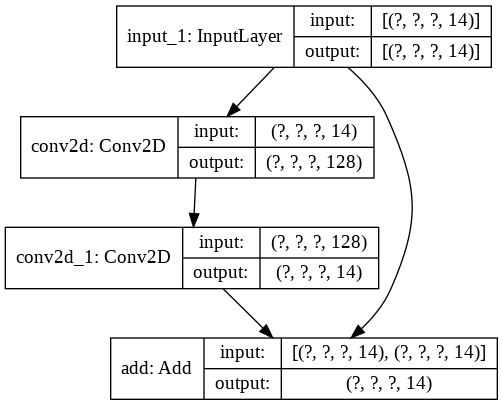

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def createAutomataModel(initializer, name="Cellular Automata for ARC"):
    # Free up RAM when creating a model multiple times
    keras.backend.clear_session()

    input = keras.Input(shape=(None, None, 10 + NUM_COMMUNICATION_CHANNELS))

    x = layers.Conv2D(
        filters=128,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(input)

    x = layers.Conv2D(
        filters=10 + NUM_COMMUNICATION_CHANNELS,
        kernel_size=1,
        padding="valid",
        activation=None,
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(x)

    x = layers.Add()([x, input])

    return keras.Model(inputs=input, outputs=x, name=name)

# Create a model just to display a summary (it won't be used)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=3e-3, seed=1337)
model = createAutomataModel(initializer)
model.summary()
display(keras.utils.plot_model(model, show_shapes=True))


In [40]:
# Custom loss function that ignores arbitrary communication channels
def custom_loss(y_true, y_pred):
    (a, b, c) = y_true[0].shape
    new_y_true = tf.slice(y_true[0], [0, 0, 0], [a, b, 10])
    new_y_pred = tf.slice(y_pred[0], [0, 0, 0], [a, b, 10])
    # Mean squared error
    # return keras.losses.MeanSquaredError()(new_y_true, new_y_pred)
    # Cross entropy
    # return tf.math.reduce_sum(
    #     tf.nn.softmax_cross_entropy_with_logits(labels=new_y_true, logits=new_y_pred))
    # Non-mean squared error
    return tf.math.reduce_sum(
        tf.math.squared_difference(new_y_true, new_y_pred))
    
def train_one_step(model, train_x, train_y, num_iterations, optimizer):
    # The model will be fed its previous predictions on each iteration,
    # so we define the first y_pred as the original inputs
    # (y_pred is a list and not a numpy array because grid sizes may differ)
    y_pred = list(map(lambda x: np.copy(x), train_x))

    # Accumulate gradient over all iterations so it can be applied in the end
    # (backpropagation through time)
    accumulated_gradient = []

    for layer in model.trainable_variables:
        accumulated_gradient.append(tf.zeros(layer.shape))

    # print("Training losses:")

    for iteration in range(num_iterations):
        avg_gradient = [] # Total gradient over all training examples

        for layer in model.trainable_variables:
            avg_gradient.append(tf.zeros(layer.shape))

        # Feed forward all example grids
        for i, grid in enumerate(y_pred):
            # Turn input and target grids into batch of 1
            input = np.array([grid])
            y = np.array([train_y[i]])

            with tf.GradientTape() as tape:
                out = model(input, training=True)
                loss = custom_loss(y, out)
                # if iteration == (num_iterations - 1):
                #     print(f"#{i}: {loss}")

            gradient = tape.gradient(loss, model.trainable_variables)
            # Replace next input with this step's output
            # (index 0 to extract from batch of size 1)
            y_pred[i] = np.array(out[0])

            for i, layer in enumerate(gradient):
                avg_gradient[i] += layer

        # Accumulate gradient
        for i, layer in enumerate(avg_gradient):
            avg_gradient[i] /= len(y_pred)
            accumulated_gradient[i] += avg_gradient[i]

    # Update weights
    optimizer.apply_gradients(zip(accumulated_gradient, model.trainable_variables))

def train(model, task, num_iterations, optimizer, max_epochs, display_result=False):
    """
    @param model: The model to be trained
    @param task: A vectorized task in the format
        { train_x: [], train_y: [], test_x: [], test_y: []}, where the lists
        are 3-dimensional.
    @param num_iterations: How many times to iterate the grid through the model
        before updating the weights.
    @param optimizer: The optimizer to use when updating the weights.
    @param max_epochs: The maximum number of times the model will be updated
        after running the input grid through it `num_iterations` times.
        This is a maximum because the model will stop training as soon as it
        has solved the test grids correctly.
    @return True as soon as the model solves the test grids correctly, otherwise
        returns False after training for `max_epochs` epochs.
    """
    print(f"Training model {model.name} for a max of {max_epochs} epochs, with {num_iterations} iterations per epoch...")
    
    for i in range(max_epochs):
        # Train model once
        train_one_step(model, task["train_x"], task["train_y"], num_iterations, optimizer)
        # Check if test grids are completed successfully
        success = evaluate(model, task["test_x"], task["test_y"], num_iterations, display_result=display_result)
        # Stop training if model is successful
        if success: return True
    
    return False

def evaluate(model, test_x, test_y, num_iterations, display_result=False):
    """
    @return True if the model completes the test grids correctly, False otherwise
    """

    # Local copy of input so we can iterate over it
    y_pred = np.copy(test_x)

    for iteration in range(num_iterations):
        for i, grid in enumerate(y_pred):
            out = model(np.array([grid]), training=False) # Batch size of 1
            y_pred[i] = out[0] # Extract result from batch

    if display_result:
        print("\nEvaluation result:")
        xs = []
        ys = []
        for i, grid in enumerate(y_pred):
            xs.append(devectorize_grid(test_x[i]))
            ys.append(devectorize_grid(test_y[i]))
            xs.append(devectorize_grid(test_x[i]))
            ys.append(devectorize_grid(grid))
        display_grid_pairs(xs, ys)
    
    # Calculate avg test loss
    loss = 0
    for i, grid in enumerate(y_pred):
        prediction = np.array([grid])
        y = np.array([test_y[i]])
        loss += custom_loss(y, prediction)
    loss /= len(y_pred)
    if (display_result):
        print(f"Average test loss: {loss}")

    # Check if test output grid predictions are correct
    for i, grid in enumerate(y_pred):
        prediction = devectorize_grid(grid)
        y = devectorize_grid(test_y[i])
        if not np.array_equal(y, prediction):
            return False

    return True

In [ ]:
# This block runs the Neural Cellular Automata model on all training tasks

# Define the number of iterations of the cellular automata rule over the grid
# before updating weights (when training) or before calculating loss
# (when evaluating)
num_iterations = 32

optimizer = keras.optimizers.Adam(learning_rate=3e-4)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.5e-2, seed=1337)
max_epochs = 10

solved_count = 0
solved_tasks = []

for i, task in enumerate(vectorized_tasks):
    task_name = task_names[i]
    model = createAutomataModel(initializer, name=task_name)
    success = train(model, task, num_iterations, optimizer, max_epochs)
    evaluate(model, task["test_x"], task["test_y"], num_iterations, display_result=True)
    if success:
        print(f"Solved task {task_name} successfully!")
        solved_count += 1
        solved_tasks.append(task_name)
    else:
        print(f"Failed to solve task {task_name}.")
    print(f"Attempted {i+1} out of {len(vectorized_tasks)} tasks.\n")
    print(f"Solved {solved_count} tasks so far:")
    print(solved_tasks)

print(f"Finished. Solved {solved_count} out of {vectorized_tasks} tasks.")



In [ ]:
# This block runs the Neural Cellular Automata model on a single task

# Define the number of iterations of the cellular automata rule over the grid
# before updating weights (when training) or before calculating loss
# (when evaluating)
num_iterations = 64

optimizer = keras.optimizers.Adam(learning_rate=3e-4)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.5e-2, seed=1337)
max_epochs = 10000

# task = vectorized_tasks[0]
# task_name = task_names[0]

task_name = "3ac3eb23.json"
i = task_names.index(task_name)
task = vectorized_tasks[i]

model = createAutomataModel(initializer, name=task_name)

success = train(model, task, num_iterations, optimizer, max_epochs, display_result=True)
if success:
    print(f"Solved task {task_name} successfully!")
else:
    print(f"Failed to solve task {task_name}.")


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
model.save("")

# Running a baseline convolutional model

In [ ]:
def createBaselineModel(initializer, name="Baseline Convolutional Model for ARC"):
    input = keras.Input(shape=(None, None, 10 + NUM_COMMUNICATION_CHANNELS))

    x = layers.Conv2D(
        filters=128,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(input)

    x = layers.Conv2D(
        filters=10 + NUM_COMMUNICATION_CHANNELS,
        kernel_size=1,
        padding="valid",
        activation=None,
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(x)

    x = layers.Add()([x, input])

    return keras.Model(inputs=input, outputs=x, name=name)

# Create a model just to display a summary (it won't be used)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=3e-3, seed=1337)
model = createNewModel(initializer)
model.summary()
display(keras.utils.plot_model(model, show_shapes=True))